# 0. Import nécessaires

In [102]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

import pandas as pd
#suppression des warnings qui peuvent être génants
import warnings
warnings.filterwarnings("ignore")

# 1. Récupération des données

In [55]:
url = "https://tinyurl.com/y4pflefj"

df = pd.read_csv(url)

# 2. Analyse des données

## 2.1 Recherches valeurs non nulles

[(0, 1), Text(0.5, 1.0, 'Pourcentage de cellules vides')]

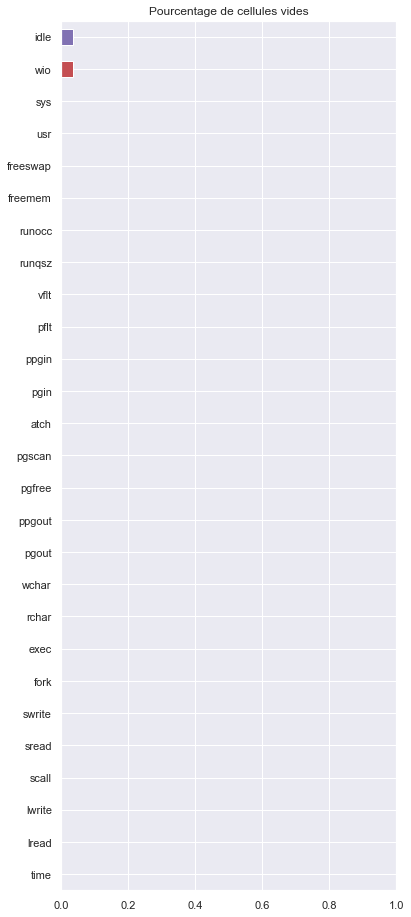

In [56]:
means = [ mean for mean in df.isnull().mean() if mean > 0]

_, ax = plt.subplots(figsize=(6,16))

df.isnull().mean().plot.barh(ax = ax)
ax.set(
    title = "Pourcentage de cellules vides",
    xlim=(0,1)
)

On remarque que les seules valeurs nulles sont des temps d'attente, on peut supposer qu'une valeur vide est une valeur nulle. De plus ces valeurs ne sont pas utilisées ici dans l'exercice

In [57]:
df = df.fillna(0)

In [32]:
df['idle'].mean()

0.0386962890625

## 2.2 Formats des données

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8192 entries, 0 to 8191
Data columns (total 27 columns):
time        8192 non-null object
lread       8192 non-null int64
lwrite      8192 non-null int64
scall       8192 non-null int64
sread       8192 non-null int64
swrite      8192 non-null int64
fork        8192 non-null float64
exec        8192 non-null float64
rchar       8192 non-null int64
wchar       8192 non-null int64
pgout       8192 non-null float64
ppgout      8192 non-null float64
pgfree      8192 non-null float64
pgscan      8192 non-null float64
atch        8192 non-null float64
pgin        8192 non-null float64
ppgin       8192 non-null float64
pflt        8192 non-null float64
vflt        8192 non-null float64
runqsz      8192 non-null float64
runocc      8192 non-null int64
freemem     8192 non-null int64
freeswap    8192 non-null int64
usr         8192 non-null int64
sys         8192 non-null int64
wio         8192 non-null float64
idle        8192 non-null float64


On remarque que toute les données sont des nombres, sauf la données time qui correspond à l'heure de la mesure. Nous allons donc transformer ces données pour n'avoir que des données numériques, qui permettrons une meilleure analyse

## 2.3 Reformatage des données
On peut supposer qu'une donnée qui va être importante pour la mesure de l'utilisation par l'utilisateur est la donnée de date de la mesure. On peut procéder de plusieurs manières pour simplifier la données, soit on sépare en trois champs, heures, minutes et secondes, ce qui risque d'induire des erreurs(la minutes 20 n'a pas le même poids pour 10h20 que pour 0h20).

Une autre manière de faire est de rajouter une colonne qui va correspondre à une sorte de temps horloge, avec le nombre de secondes écoulés depuis 0h.

Nous allons procéder de la seconde manière

In [58]:
def seconds_from_midnight(date):
    """Fonction qui renvoie le nombre de secondes écoulées depuis 00:00:00 avec une chaine de charactere au format hh:mm:ss"""
    # Séparation de la date avec la méthode split, pour récupérer la composante d'heure, minutes et secondes
    splitted = date.split(':')
    return 3600 * float(splitted[0]) + 60 * float(splitted[1]) + float(splitted[2])

In [59]:
# On ajoute cette nouvelle colonne à notre dataframe en appliquant la fonction que l'on vient de créer
df['seconds'] = df.apply(lambda row: seconds_from_midnight(row.time), axis = 1)

# On enlève alors la colonne time qui n'a plus d'importance pour le moment

df = df.drop(columns=['time'])

Les autres colonnes d'utilisation du CPU ne sont pas des paramètres à prendre en compte, on peut également les supprimer

In [60]:
df = df.drop(columns=['sys', 'wio', 'idle'])

##  2.4 Analyse visuelle des données

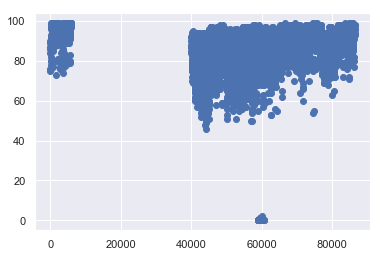

In [61]:
# On vient voir si la nouvelle colonne que l'on a créer "seconds" a un vrai impact ou non sur la colonne "usr"
plt.scatter(df['seconds'], df['usr'])

On remarque alors que la colonne que l'on a créé ne permet pas forcément de discriminer l'utilisation du CPU, elle nous indique juste les moments où l'on a utilisé ou non l'ordinateur

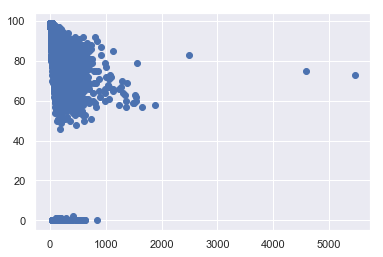

In [62]:
plt.scatter(df['swrite'], df['usr'])

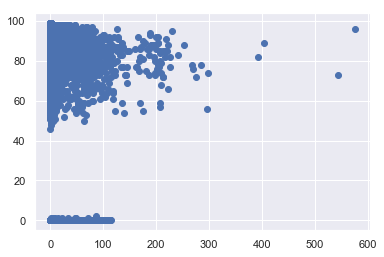

In [63]:
plt.scatter(df['lwrite'], df['usr'])

Globalement, on remarque qu'une données seule ne permet pas d'expliquer simplement l'utilisation du CPU

# 3. Mise en place de la regression

In [89]:
# Séparation des valeurs
from sklearn.model_selection import train_test_split

# Mesure de l'efficacité
from sklearn.metrics import r2_score, mean_squared_log_error

# import du pipeline
from sklearn.pipeline import Pipeline

# Imports des regresseurs possibles
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Import des scaleurs
from sklearn.preprocessing import StandardScaler, QuantileTransformer

## 3.1 Création d'une fonction de calcul du score en fonction d'un régresseur

In [65]:
def calc_func_score(X, y, reg = LinearRegression(), nb_counts=10, func=r2_score):
    """
    Fonction qui vient à partir d'un X et d'un y, fournir la liste des scores obtenus par le régresseur
    La fonction de score utilisée de base est r2_score
    Le nombre d'itérations de base est 10
    """
    scores = []
    for i in range(nb_counts):
        
        # Séparation des données
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    
        # Apprentissage
        reg.fit(X_train, y_train)
        
        # Prédiciton
        y_pred = reg.predict(X_test)
        
        # Calcul et ajout du score à la liste
        
        scores.append(func(y_test, y_pred))
    
    return scores
        

In [157]:
X = df
y = df['usr']

## 3.2 Mise en place fonction génération pipeline

Étant donné que les éléments utilisés sont des nombres, et que leurs répartitions dépend beaucoup, il faut les mettres à l'échelles.
Il n'est pas nécéssaire d'utiliser un ColumnTRansformer, vu que toutes les données sont des nombres

In [99]:
def create_pipeline(reg = LinearRegression(), scaler = StandardScaler()):
    """Fonction qui vient créer le pipelien selon la forme que l'on souhaite""" 
    return Pipeline(steps=[
        ('scaler', scaler),
        ('reg', reg)
    ])

Nous allons maintenant modifier la fonction que nous avons créé précédemment pour pouvoir fournir un scaler à utiliser

In [100]:
def calc_func_score(X, y, reg = LinearRegression(), nb_counts=10, func=r2_score, scaler = StandardScaler()):
    """
    Fonction qui vient à partir d'un X et d'un y, fournir la liste des scores obtenus par le régresseur
    La fonction de score utilisée de base est r2_score
    Le nombre d'itérations de base est 10
    """
    scores = []
    for i in range(nb_counts):
        
        # Séparation des données
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
        
        # Création du pipeline
        pipeline = create_pipeline(reg, scaler)
        
        # Apprentissage
        pipeline.fit(X_train, y_train)
        
        # Prédiciton
        y_pred = pipeline.predict(X_test)
        
        # Calcul et ajout du score à la liste
        
        scores.append(func(y_test, y_pred))
    
    return scores

# 4.0 Calcul du score pour le regresseur linéaire

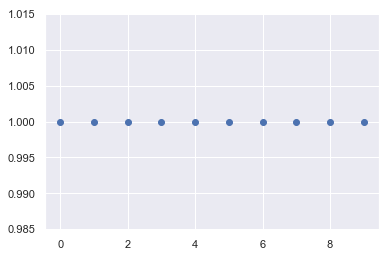

In [159]:
scores = calc_func_score(X,y)

plt.scatter(x=range(len(scores)), y=scores)

On remarque alors que le score est parfait. En effet nous avons mis dans les données d'apprentissage et de test les valeurs que l'on doit trouver. Il est simple de le deviner, notamment pour un regresseur linéaire dont le but est d'approcher la fonction par une droite, d'utiliser comme droite la droite d'équation usr = usr

# 5.0 Recherche du meilleur regresseur

In [160]:
def set_default_values(df):
    """Fonction qui vient fournir le X et le y de base pour ce qui nous concerne"""
    return df.drop(columns=['usr']), df['usr']

On obtient un score très bon pour un regresseur linéaire, on va toute de même voir si l'on peut être plus précis

In [161]:
def compare_regressors(regressors, df,nb_counts = 10):
    """Fonction qui vient fournir la liste des scores pour une liste de regresseur donnée"""
    #Récupération des valeurs initiales
    X, y = set_default_values(df)
    
    scores = []
    # Pour chaque régresseur, on vient ajouter son score
    for reg in regressors:
        scores.append(calc_func_score(X, y, reg, nb_counts = nb_counts))
    
    return scores

In [162]:
regressors = [
    LinearRegression(),
    SVR(gamma='auto'),
    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    AdaBoostRegressor(),
    DummyRegressor()
]

score_regressors_means = [(np.mean(score), np.std(score)) for score in compare_regressors(regressors, df)]

In [163]:
for i in range(len(regressors)):
    score = score_regressors_means[i]
    print(f"Régresseur {type(regressors[i]).__name__} : {score[0]:.3f} +/- {score[1]:.3f}")

Régresseur LinearRegression : 0.976 +/- 0.002
Régresseur SVR : 0.840 +/- 0.015
Régresseur KNeighborsRegressor : 0.968 +/- 0.005
Régresseur DecisionTreeRegressor : 0.965 +/- 0.003
Régresseur AdaBoostRegressor : 0.943 +/- 0.004
Régresseur DummyRegressor : -0.001 +/- 0.001


On remarque alors que visiblement le regresseur le plus efficace est la régression linéaire, c'est désormaire celui ci que nous allons utiliser dorénavent

# 6. Recherche des meilleurs combinaisons de colonnes

On peut procéder de plusieurs façon pour connaître la meilleur combinaisons de colonnes pour un nombre de colonnes fixés. Soit nous procédons par itération, nous chercher la première la plus efficace, puis celle qui est la plus efficace combinés à celle que l'on a calculé précédemment..

Cette méthode permet d'avoir une réponse approchée en un temps raisonnable

Si l'on veut connaître les meilleurs combinaisons, ils faut faire les tests sur toutes les combinaisons possibles

In [84]:
reg = LinearRegression()

### 6.1 Recherche par itération successives

In [107]:
def score_by_columns(df, columns, reg = LinearRegression(), nb_counts = 10):
    """Fonction qui vient renvoyer la liste des scores pour une liste de colonnes données"""
    # On récupère les valeurs initiales
    X, y = set_default_values(df)
    
    X = X.loc[:, columns]
    
    return calc_func_score(X, y, reg, nb_counts = nb_counts)

In [123]:
def scores_by_columns_count(df, n,reg = LinearRegression(), nb_counts = 10):
    """Fonction qui vient fournir la liste des meilleurs combinaisons de colonnes entre 1 et count"""
    result = []
    # available_columns contient la liste des colonnes disponibles 
    available_columns = [col for col in df.drop(columns='usr').columns]
    # used_columns contient les différents éléments que nous avons identifié
    used_columns = []
    for i in range(n):
        scores = []
        # On itère sur chaque colonne qui est présente dans les colonnes disponibler
        for col in available_columns:
            # on génère la liste des colonnes en concaténant la liste des colonnes sélectionnées précédemment et la colonne courante 
            
            cols = used_columns + [col]
            col_scores = score_by_columns(df, cols)
            scores.append((col,np.mean(col_scores)))
        # On vient chercher la colonne avec le meilleur score
        max_score = (None, 0)
        for score in scores:
            if(score[1] > max_score[1]):
                max_score = score
        # Une fois que la meilleur colonne est identifiée, on vient l'ajouter à la liste des meilleurs colonnes
        used_columns.append(max_score[0])
        # On la supprime également des colonnes disponibles
        available_columns.remove(max_score[0])
        result.append(max_score)
    return result

In [124]:
scores = scores_by_columns_count(df,20)

In [167]:
def columns_by_best_score_count(df, n):
    """Fonction qui renvoie la liste des n-meilleurs colonnes"""
    scores = scores_by_columns_count(df,n)
    return ([x[0] for x in scores], scores[n-1])

In [129]:
columns = columns_by_best_score_count(df, 20)

In [131]:
columns

['runocc',
 'vflt',
 'scall',
 'ppgin',
 'exec',
 'rchar',
 'lread',
 'wchar',
 'pflt',
 'pgout',
 'ppgout',
 'freemem',
 'pgscan',
 'seconds',
 'swrite',
 'runqsz',
 'sread',
 'pgin',
 'lwrite',
 'freeswap']

## 6.2 Recherche par arangements

On a besoin de générer les combinaisons, pour cela nous allons utiliser la librairie suivante

In [164]:
import itertools

In [154]:
def columns_by_arangements(df, n, reg = LinearRegression(), nb_counts = 10):
    """Fonction qui vient calculer le score moyen pour toute les combinaisons de n colonnes et renvoie la liste avec le score moyen"""
    # on récupère la liste des colonnes disponibles(hormis usr, cf #4)
    available_columns = [col for col in df.drop(columns='usr').columns]
    # On génère les combinaisons possibles
    combinations = [list(cols) for cols in itertools.combinations(available_columns, n)]
    scores = []
    for cols in combinations:
        col_scores = score_by_columns(df, cols)
        scores.append((cols, np.mean(col_scores)))
    return scores

In [165]:
def best_columns_by_columns_count(df, n, reg = LinearRegression(), nb_counts = 10):
    """Fonction qui renvoie les meilleurs colonnes parmis les combinaisons de n éléments"""
    # on recupère la liste des scores par arangements
    scores = columns_by_arangements(df, n, reg, nb_counts)
    # on récupère le meilleur score possible
    max_score = (None, 0)
    for score in scores:
        if(score[1] > max_score[1]):
            max_score = score
    return max_score

In [166]:
best_columns_by_columns_count(df, 5)

(['scall', 'exec', 'pgin', 'vflt', 'runocc'], 0.97023154480353)

### 6.3 Comparaisons des deux méthodes

A l'utilisation, on se rends compte que la recherche par arangements est beaucoup plus long.
Intuitivement la complexité de la première méthode est de l'ordre de O(n²), tandis que l'autre est de l'ordre de O(n!)

Au vu des scores que l'on obtient, on va plutôt utiliser la méthode présentée dans le 6.1, méthode qui est beaucoup plus rapide.

On va toute de même créer une méthode pour comparer les résultats obtenus, tout en stockant également le temps de traitement

In [171]:
import time
def compare_columns_methods(df,n,reg = LinearRegression(), nb_counts = 10):
    # On stocke le résultat et le temps passé pour traiter le premier cas
    t0 = time.time()
    first_score = columns_by_best_score_count(df, n, reg, nb_counts)
    
    t1 = time.time()
    second_score = best_columns_by_columns_count(df,nb_counts, reg, nb_counts)
    t2 = time.time()
    
    return [(first_score, t1 - t0), (second_score, t2 - t1)]

## 6.4 Résultats

Visiblement les deux algorithmes donnent des résultats similaires, les 5 meilleurs colonnes seraient :
- scall
- exec
- pgin
- vlft
- runocc
Pour un score supérieur à 0.97